@author Emanuel Skodinis (emanuesk@ethz.ch)

Analyses the performance of the Parking Guidance System (PGS) in comparison to manual searches.

    1. Mean travel time per group. Note: this ist not the time of the parking search but the whole trip.
    2. Mean proximity to destination per group.
    3. Mean of free parking spots passed during parking guidance per trip. Note: this considers all parking spots
    4. Mean of rerouting events during parking guidance per trip.
    5. Mean of failure (since no free parking space found within stop-radius by PGS) for guided trips.

Script for Via:

// network
networkData = via.createDataset("/Users/emanuesk/Documents/PGSFiles/grid_network.xml");
networkLayer = via.createLayer("network", networkData);

// vehicles
eventsData = via.createDataset("/Users/emanuesk/Documents/GitHub/output/parkingSearch/ITERS/it.0/0.events.xml");
vehicles = via.createLayer("vehicles", networkData, eventsData);
vehicles.loadEvents();

// occupation (xy-plotter)
xyData = via.createDataset("/Users/emanuesk/Documents/PGSFiles/occupation.csv");
xyLayer = via.createLayer("xy", xyData);
xyLayer.name = "MyData-XY"

- Number of Trips -
Algorithm         Trips
--------------------------------
PGS                60.0
random            140.0


- Mean travel time -
Algorithm       Minutes    Seconds
--------------------------------
PGS                16.0      53.22
random             33.0      15.69


- Mean proximity to destination -
Algorithm        Meters
--------------------------------
PGS               351.5
random            562.0


- Mean passing of free parking during parking guidance -
Passing on average 1.25 free parking spots per trip.


- Mean reroutings during parking guidance -
Rerouting on average 0.13333333333333333 times per trip.


- Mean PGS fails to provide guidance -
Fails on average 0.0 times per trip.




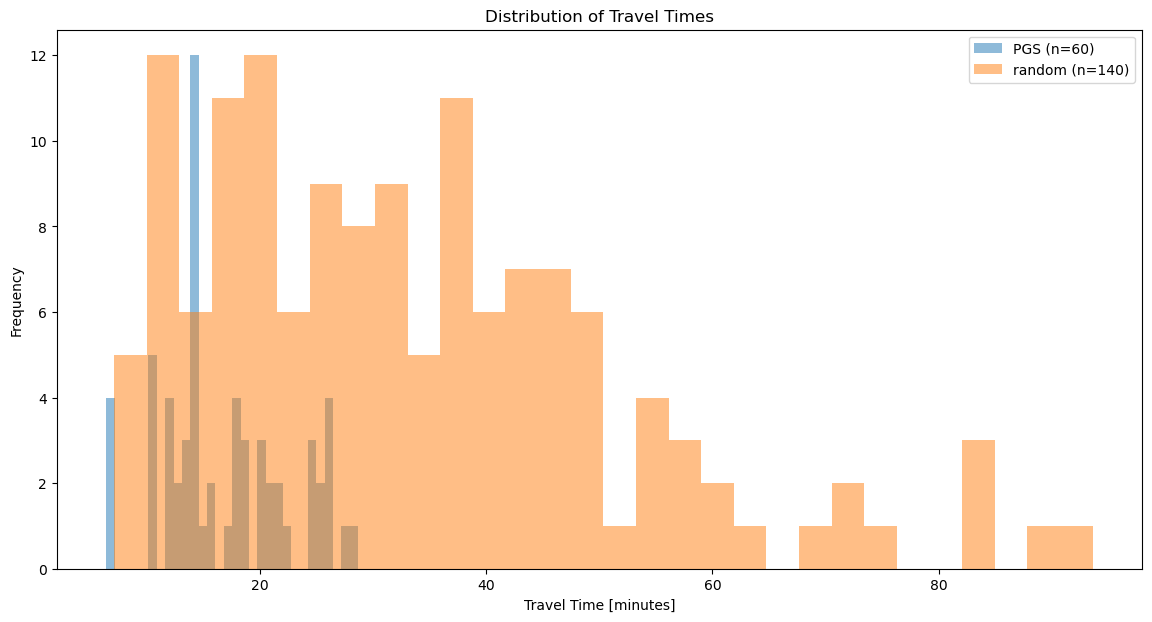

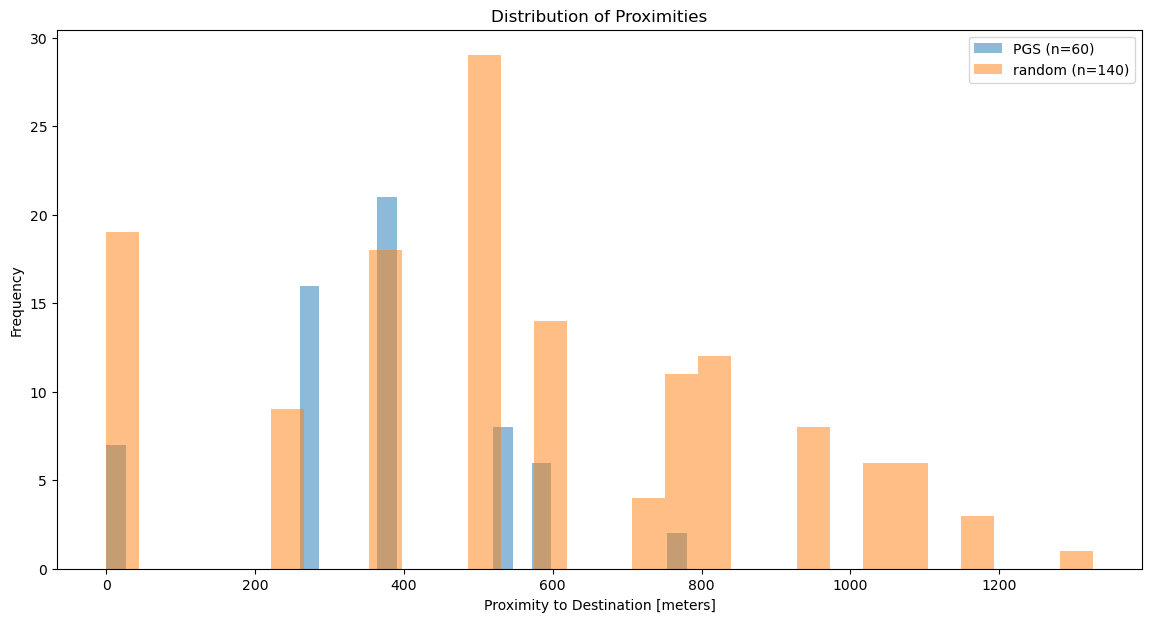

In [4]:
import xml.etree.ElementTree as ET
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt
import gzip


#====================================================================================================================================================================
# PATH TO EVENTS XML FILE
#====================================================================================================================================================================

file_path_gzip = '/Users/emanuesk/Documents/GitHub/output/parkingSearch/ITERS/it.0/0.events.xml.gz'
file_path_xml = '/Users/emanuesk/Documents/GitHub/output/parkingSearch/ITERS/it.0/0.events.xml'

#====================================================================================================================================================================


#====================================================================================================================================================================
# CONSTANTS
#====================================================================================================================================================================

TRENNER = '\n' + "=" * 35 + '\n'
TABLE_TRENNER = "-" * 32

PGS = 'PGS'

EVENT = 'event'

TIME = 'time'

TYPE = 'type'
ACTEND = 'actend'
ACTSTART = 'actstart'
PERSON_LEAVES_VEHICLE = 'PersonLeavesVehicle'
TRAVELLED = 'travelled'
DISTANCE = 'distance'
PASSING_FREE_PARKING = 'passing free parking'
REROUTING = 'rerouting'
GUIDANCE_FAILED = 'guidance failed'

PERSON = 'person'
VEHICLE = 'vehicle'

ACT_TYPE = 'actType'
HOME = 'home'
WORK = 'work'

#====================================================================================================================================================================


#====================================================================================================================================================================
# Helper function to extract group from person ID
#====================================================================================================================================================================

def get_group(person):
    return person.split('_')[-1]

#====================================================================================================================================================================

#====================================================================================================================================================================
# decompress gzip to xml
#====================================================================================================================================================================

with gzip.open(file_path_gzip, 'rb') as file_gzip:
    decompressed_data = file_gzip.read()

    with open(file_path_xml, 'wb') as file_xml:
        file_xml.write(decompressed_data)

#====================================================================================================================================================================


#====================================================================================================================================================================
# COLLECT INFO
#====================================================================================================================================================================

# Load and parse the XML file
tree = ET.parse(file_path_xml)
root = tree.getroot()

# Initialize a dictionary to store the leave home and reach work times
departure_times = {}
group_times = defaultdict(list)
group_num_trips = defaultdict(int)
person_left_vehicle = defaultdict(bool)
group_proximities = defaultdict(list)
passing_free_parking_counter = 0
rerouting_counter = 0
guidance_failure_counter = 0

# Iterate over each event in the XML
for event in root.findall(EVENT):
    time = float(event.get(TIME))
    event_type = event.get(TYPE)
    act_type = event.get(ACT_TYPE)
    person = event.get(PERSON)
    distance = event.get(DISTANCE)
    vehicle = event.get(VEHICLE)

    if event_type == ACTEND and (act_type == HOME or act_type == WORK):
        # Person departs
        departure_times[person] = time
    elif event_type == ACTSTART and (act_type == WORK or act_type == HOME):
        # Person arrives
        departure_time = departure_times[person]
        travel_time = time - departure_time

        group = get_group(person)
        group_times[group].append(travel_time)
        group_num_trips[group] += 1
    elif event_type == PERSON_LEAVES_VEHICLE:
        person_left_vehicle[person] = True
    elif event_type == TRAVELLED and person_left_vehicle[person]:
        group = get_group(person)
        group_proximities[group].append(float(distance))
        person_left_vehicle[person] = False
    elif event_type == PASSING_FREE_PARKING:
        passing_free_parking_counter += 1
    elif event_type == REROUTING:
        rerouting_counter += 1
    elif event_type == GUIDANCE_FAILED:
        guidance_failure_counter += 1

#====================================================================================================================================================================


#====================================================================================================================================================================
# CALCULATE MEANS AND SORT
#====================================================================================================================================================================

# Calculate mean travel times per group
group_time_means = {}
for group, times in group_times.items():
    mean = statistics.mean(times)
    group_time_means[group] = mean

# Calculate mean proximity to destination per group
group_proximity_means = {}
for group, proximities in group_proximities.items():
    mean = statistics.mean(proximities)
    group_proximity_means[group] = mean

num_PGS_trips = group_num_trips[PGS]

# Calculate mean free parking passing
passing_free_parking_mean = passing_free_parking_counter / num_PGS_trips

# Calculate mean rerouting
rerouting_mean = rerouting_counter / num_PGS_trips

# Calculate mean guidance failure
guidance_failure_mean = guidance_failure_counter / num_PGS_trips

# sort means to rank the algorithms
sorted_group_num_trips = dict(sorted(group_num_trips.items(), key=lambda item: item[1]))
sorted_group_time_means = dict(sorted(group_time_means.items(), key=lambda item: item[1]))
sorted_group_proximity_means = dict(sorted(group_proximity_means.items(), key=lambda item: item[1]))

#====================================================================================================================================================================


#====================================================================================================================================================================
# PRINT INFO
#====================================================================================================================================================================

print("- Number of Trips -")
print(f"{'Algorithm':<15} {'Trips':>7}")
print(TABLE_TRENNER)

for group, num_trips in sorted_group_num_trips.items():
    print(f"{group:<15} {num_trips:>7.1f}")

print(TRENNER)

print("- Mean travel time -")
print(f"{'Algorithm':<15} {'Minutes':>7} {'Seconds':>10}")
print(TABLE_TRENNER)

for group, mean in sorted_group_time_means.items():
    mins = int(mean // 60)
    secs = mean % 60
    print(f"{group:<15} {mins:>7.1f} {secs:>10.2f}")

print(TRENNER)

print("- Mean proximity to destination -")
print(f"{'Algorithm':<15} {'Meters':>7}")
print(TABLE_TRENNER)

for group, mean in sorted_group_proximity_means.items():
    print(f"{group:<15} {mean:>7.1f}")

print(TRENNER)

print("- Mean passing of free parking during parking guidance -")
print(f"Passing on average {passing_free_parking_mean} free parking spots per trip.")

print(TRENNER)

print("- Mean reroutings during parking guidance -")
print(f"Rerouting on average {rerouting_mean} times per trip.")

print(TRENNER)

print("- Mean PGS fails to provide guidance -")
print(f"Fails on average {guidance_failure_mean} times per trip.")

print(TRENNER)

#====================================================================================================================================================================


#====================================================================================================================================================================
# PLOT TRIP TIMES AND PROXIMITIES
#====================================================================================================================================================================

# Plot the trip times
plt.figure(figsize=(14, 7))

for group, times in group_times.items():
    plt.hist([time / 60 for time in times], bins=30, alpha=0.5, label=f"{group} (n={len(times)})")

plt.xlabel('Travel Time [minutes]')
plt.ylabel('Frequency')
plt.title('Distribution of Travel Times')
plt.legend(loc='upper right')
plt.show()

# Plot the trip times
plt.figure(figsize=(14, 7))

for group, proximities in group_proximities.items():
    plt.hist(proximities, bins=30, alpha=0.5, label=f"{group} (n={len(proximities)})")

plt.xlabel('Proximity to Destination [meters]')
plt.ylabel('Frequency')
plt.title('Distribution of Proximities')
plt.legend(loc='upper right')
plt.show()

#====================================================================================================================================================================